# Vision part of the Mobile Robotics project

## Notes about the project and innput advancement

Dimensions of the thymio : 11 cm x 11.2 cm x 5.3 cm (https://wiki.thymio.org/fr:thymiospecifications).

I'll then choose 12-cm side squares for the start and end of the thymio, respectively green and blue.

## Imports

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

### Loading image

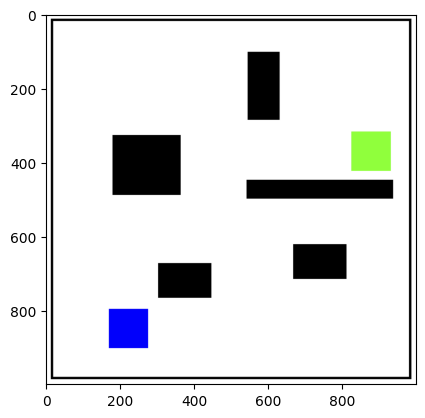

In [44]:
# Load the image
image = cv2.imread('map_mobile_robotics2.jpeg')

#Resize this image to 1mx1m
image = cv2.resize(image, (1000, 1000))

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.show()

## Preprocessing

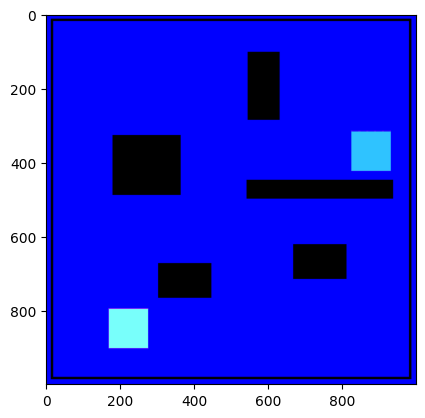

In [45]:
# Convert the image to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Display the image
plt.imshow(hsv)
plt.show()

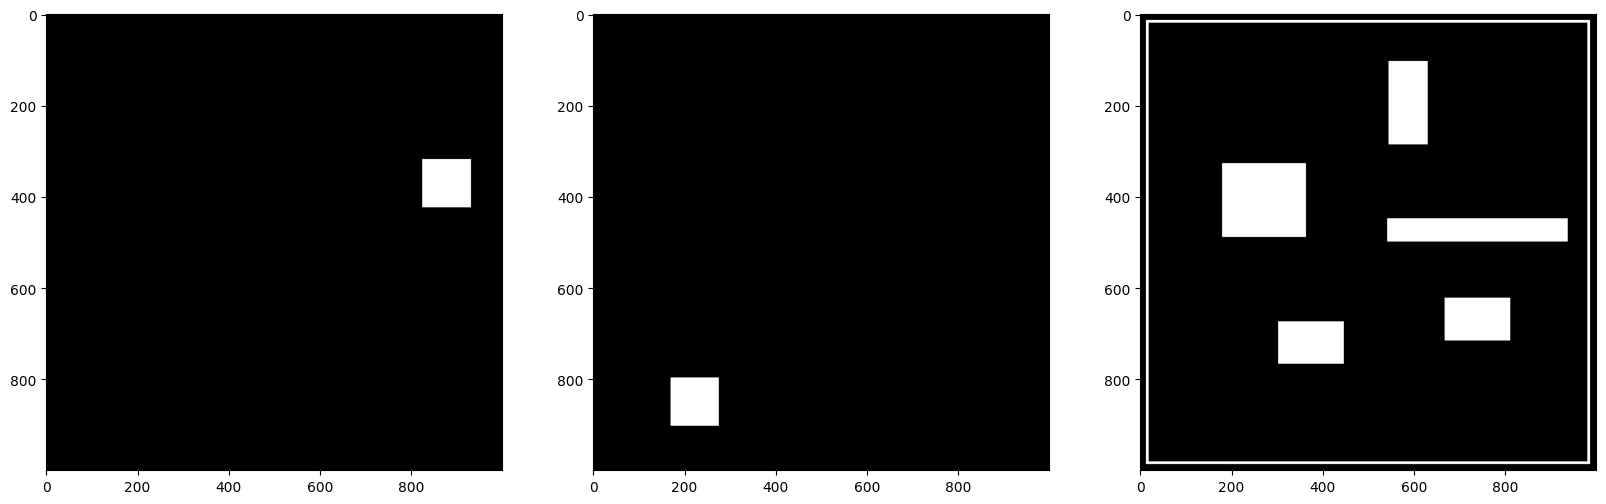

In [46]:
# Define color ranges for green squares
green_lower = np.array([35, 100, 100])
green_upper = np.array([85, 255, 255])
green_mask = cv2.inRange(hsv, green_lower, green_upper)

# Define color ranges for blue squares
blue_lower = np.array([100, 100, 100])
blue_upper = np.array([140, 255, 255])
blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

# Define color ranges for black squares or rectangles
black_lower = np.array([0, 0, 0])
black_upper = np.array([180, 255, 30])
black_mask = cv2.inRange(hsv, black_lower, black_upper)

#display the 3 masks
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(green_mask, cmap="gray")
plt.subplot(132)
plt.imshow(blue_mask, cmap="gray")
plt.subplot(133)
plt.imshow(black_mask, cmap="gray")
plt.show()


In [47]:
# Find contours for each colour
green_contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _ = cv2.findContours(black_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours = black_contours[2:] # Exclude the map contour

# Display the variables
print("Green contours: ", len(green_contours))
print("Blue contours: ", len(blue_contours))
print("Black contours: ", len(black_contours))

Green contours:  1
Blue contours:  1
Black contours:  5


In [48]:
# Draw contours on the original image

cv2.drawContours(image, black_contours, -1, (0, 255, 255), 3);  # Yellow    color for   black   squares
cv2.drawContours(image, green_contours, -1, (0, 165, 255), 3);  # Orange    color for   green   squares
cv2.drawContours(image, blue_contours, -1, (255, 0, 0), 3);     # Yellow    color for   blue    squares


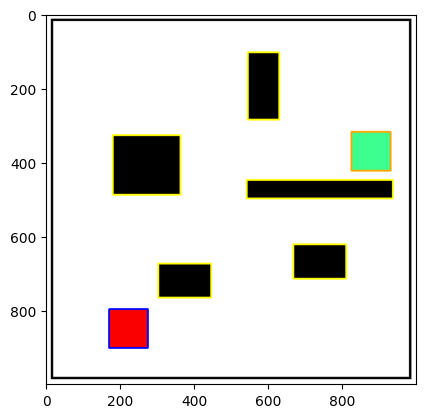

In [49]:
# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.show()

# Approximate contours to polygons and detect quadrilaterals for each color
for color_contours in [blue_contours, green_contours, black_contours]:
   for cnt in color_contours:
       rectangle = cv2.minAreaRect(cnt)
       (center_x, center_y), (width, height), angle = rectangle
       if abs(width - height) < 400:
           print(f'Quadrilateral found at coordinates: {center_x}, {center_y}')


In [50]:
for cnt in blue_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Blue square found at coordinates: {x}, {y}')

for cnt in green_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Green square found at coordinates: {x}, {y}')

for cnt in black_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Black square found at coordinates: {x}, {y}')


Blue square found at coordinates: 170, 797
Green square found at coordinates: 825, 318
Black square found at coordinates: 303, 674
Black square found at coordinates: 668, 622
Black square found at coordinates: 542, 448
Black square found at coordinates: 180, 327
Black square found at coordinates: 545, 103


In [51]:
def find_coordinates(contours, color):
    coordinates = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            rectangle = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rectangle)
            box = np.intp(box)
            if color == 'Black':
                coordinates.append(box)
            elif color in ['Green', 'Blue']:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    coordinates.append([(cX, cY)])
    return coordinates


In [52]:
# Define the coordinates of the map
map_coordinates = [(0, 0), (0, 1000), (1000, 1000), (1000, 0)]

# Blue squares
blue_coordinates = []
blue_coordinates = find_coordinates(blue_contours, 'Blue')

# Green squares
green_coordinates = []
green_coordinates = find_coordinates(green_contours, 'Green')

# Black rectangles
black_coordinates = []
black_coordinates = find_coordinates(black_contours, 'Black')


blue_coordinates.sort(key=lambda x: x[0][0])
green_coordinates.sort(key=lambda x: x[0][0])
black_coordinates.sort(key=lambda x: x[0][0])

#Alternatively, if you want to ensure all the boxes are sorted in a specific manner, you might consider calculating their centroids and using these for sorting:

def sort_by_centroid(coordinates):
    centroids = [np.mean(box, axis=0) for box in coordinates]
    coordinates.sort(key=lambda box: np.mean(box, axis=0)[0])  # Sort by x-coordinate of centroid
    return coordinates

blue_coordinates = sort_by_centroid(blue_coordinates)
green_coordinates = sort_by_centroid(green_coordinates)
black_coordinates = sort_by_centroid(black_coordinates)

# Convert lists to tuples after sorting
blue_coordinates = [tuple(coord) for coord in blue_coordinates]
green_coordinates = [tuple(coord) for coord in green_coordinates]
black_coordinates = [tuple(coord) for coord in black_coordinates]

# Display the coordinates and type of variables 
print("Blue coordinates: ", blue_coordinates)
print("Green coordinates: ", green_coordinates)
print("Black coordinates: ", black_coordinates)

#print size of each list
print("Blue coordinates: ", len(blue_coordinates))
print("Green coordinates: ", len(green_coordinates))
print("Black coordinates: ", len(black_coordinates))

print(black_coordinates)

Blue coordinates:  [((222, 849),)]
Green coordinates:  [((878, 370),)]
Black coordinates:  [(array([180, 327]), array([363, 327]), array([363, 488]), array([180, 488])), (array([303, 674]), array([446, 674]), array([446, 766]), array([303, 766])), (array([545, 103]), array([630, 103]), array([630, 285]), array([545, 285])), (array([542, 448]), array([937, 448]), array([937, 498]), array([542, 498])), (array([668, 622]), array([811, 622]), array([811, 715]), array([668, 715]))]
Blue coordinates:  1
Green coordinates:  1
Black coordinates:  5
[(array([180, 327]), array([363, 327]), array([363, 488]), array([180, 488])), (array([303, 674]), array([446, 674]), array([446, 766]), array([303, 766])), (array([545, 103]), array([630, 103]), array([630, 285]), array([545, 285])), (array([542, 448]), array([937, 448]), array([937, 498]), array([542, 498])), (array([668, 622]), array([811, 622]), array([811, 715]), array([668, 715]))]


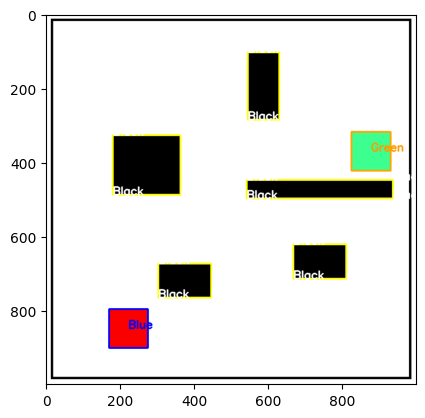

In [59]:
#Next to each square or rectangle, we will write the label of the square or rectangle inside the square or rectangle
def write_colour_label(image, coordinates_list, color):
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    color_text_map = {
        'Black': (255, 255, 255),   # White text for Black contour
        'Green': (0, 155, 255),     # Orange text for Green contour 
        'Blue' : (255, 0, 0),       # Yellow text for Blue contour
    }

    text_color = color_text_map.get(color, (255, 255, 255))  # Default to white if no mapping found

    for coordinates in coordinates_list:
        for coord in coordinates:
            if len(coord) == 1:
                x, y = coord[0]  # Extract x and y from the single coordinate
            else:
                x, y = coord  # Extract x and y from the tuple
            cv2.putText(image, color, (x, y), font, 1, text_color, 2, cv2.LINE_AA)

    return image


# Write text for blue squares
image = write_colour_label(image, blue_coordinates, 'Blue')

# Write text for green squares
image = write_colour_label(image, green_coordinates, 'Green')

# Write text for black rectangles
image = write_colour_label(image, black_coordinates, 'Black')

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [55]:
# Convert lists to tuples after sorting
# Normally no need for these lines as the coordinates already are tuples
blue_coordinates  = [tuple(coord) for coord in blue_coordinates]
green_coordinates = [tuple(coord) for coord in green_coordinates]
black_coordinates = [tuple(coord) for coord in black_coordinates]

Measurement noise matrix : x position and y position of the thymio is there is 

## Displaying the video

In [ ]:
def on_trackbar(val):
    global brigh
    mode = val

def camera_thread():
    try:
        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Error opening video stream or file")
            return
        mode = 'all'
        color_type = 'RGB'
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cam.zoom_frame(frame,zoom_factor=1)
            frame, end, start, obstacles = cam.obstacle_detection(frame,mode,color_type)

            cv2.imshow("Frame", frame)

            key = cv2.waitKey(25) & 0xFF
            if key == 27:  # ESC key to exit
                break
            elif key == ord('1'):  # '1' key to switch to blue mode
                mode = 'blue'
            elif key == ord('2'):  # '2' key to switch to green mode
                mode = 'green'
            elif key == ord('3'):  # '3' key to switch to black mode
                mode = 'black'
            elif key == ord('4'):  # '4' key to switch to black mode
                mode = 'all'
            elif key == ord('5'):  # '5' key to switch to RGB mode
                color_type = 'RGB'
            elif key == ord('6'):  # '6' key to switch to BGR mode
                color_type = 'BGR'

            time.sleep(0.01)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print("Done displaying the video")



In [ ]:
cam_thread= threading.Thread(target=camera_thread)

In [ ]:
#cam_thread.start()
camera_thread()

Done displaying the video


## Filtering

In [ ]:
import matplotlib.colors as colors
def color_to_hsv(color):
    color = color/255
    hsv = colors.rgb_to_hsv(color)
    hsv[0][0] = hsv[0][0]*360
    hsv[0][1] = hsv[0][1]*255
    hsv[0][2] = hsv[0][2]*255
    return hsv.astype(np.uint8)

GREEN_RGB = np.array([[0, 255, 0]], dtype=np.uint8)
GREEN_HSV = color_to_hsv(GREEN_RGB)
print("Green in RGB: ", GREEN_RGB)
print("Green in HSV: ", GREEN_HSV)


Green in RGB:  [[  0 255   0]]
Green in HSV:  [[120 255 255]]


In [ ]:
def hsv_range(base_color, color_threashold,saturation_threshold, brightness_threshold):
    # Convert base color to HSV
    hsv_base_color = color_to_hsv(base_color)
    # Extract hue, saturation and value from base color
    h, s, v = hsv_base_color[0, 0, :]
    
    # Define lower and upper bounds for hue
    lower_hue = h - color_threashold
    upper_hue = h + color_threashold
    if lower_hue < 0:
        lower_hue = 360 + lower_hue
    if upper_hue > 360:
        upper_hue = upper_hue - 360
    
    lower = np.array([lower_hue, saturation_threshold, brightness_threshold], dtype=np.uint8)
    upper = np.array([upper_hue, 255, 255], dtype=np.uint8)

    return lower, upper

print(hsv_range(GREEN_RGB, 0, 50, 50))

(array([60, 50, 50], dtype=uint8), array([ 60, 255, 255], dtype=uint8))


## Filtering